<a href="https://colab.research.google.com/github/MpRonald/Deep-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import zipfile

In [2]:
#loading imagenet
model = tf.keras.applications.ResNet152(weights='imagenet')

242909184/242900224 [==============================] - 5s 0us/step


In [3]:
path = '/content/drive/MyDrive/Datasets/Transfer-Learning-Data 1.zip'
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [4]:
# testing model pre trained
sample_image = tf.keras.preprocessing.image.load_img\
    (r'/content/Transfer Learning Data/bicycle.png', target_size=(224,224))

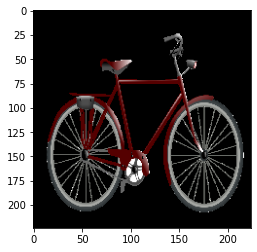

In [5]:
plt.imshow(sample_image);

In [6]:
type(sample_image)

PIL.Image.Image

In [7]:
# reshaping
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
type(sample_image)

numpy.ndarray

In [8]:
np.shape(sample_image)

(224, 224, 3)

In [9]:
sample_image = np.expand_dims(sample_image, axis=0)
sample_image.shape

(1, 224, 224, 3)

In [10]:
sample_image.min(), sample_image.max()

(0.0, 255.0)

In [13]:
# scaling
sample_image = tf.keras.applications.resnet.preprocess_input(sample_image)
sample_image.min(), sample_image.max()

(-123.68, 151.061)

In [14]:
predictions = model.predict(sample_image)
tf.keras.applications.resnet.decode_predictions(predictions, top=3)

49152/35363 [=========================================] - 0s 0us/step


[[('n02835271', 'bicycle-built-for-two', 0.86098933),
  ('n03792782', 'mountain_bike', 0.10452918),
  ('n04482393', 'tricycle', 0.012848183)]]

In [16]:
base_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False)

234708992/234698864 [==============================] - 6s 0us/step


In [17]:
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

In [21]:
X = base_model.output
X = tf.keras.layers.GlobalAveragePooling2D()(X)
X = tf.keras.layers.Dense(2048, activation='relu')(X)
X = tf.keras.layers.Dense(2048, activation='relu')(X)
X = tf.keras.layers.Dense(2048, activation='relu')(X)
X = tf.keras.layers.Dense(1024, activation='relu')(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
preds = tf.keras.layers.Dense(2, activation='softmax')(X)

In [23]:
final_model = tf.keras.models.Model(inputs=base_model.input, outputs=preds)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [24]:
for i, l in enumerate(final_model.layers):
    print(i, l.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [26]:
# frozen layers
for layer in final_model.layers[:515]:
    layer.trainable = False

In [27]:
# training others layers
for layer in final_model.layers[515:]:
    layer.trainable = True

In [31]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [32]:
train_generator = train_datagen.flow_from_directory(
    '/content/Transfer Learning Data/train',
    target_size = (224,224),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True)

Found 202 images belonging to 2 classes.


In [33]:
final_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = final_model.fit_generator(generator=train_generator, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


7/7 [==============================] - 11s 295ms/step - loss: 3.1119 - accuracy: 0.5297
Epoch 2/10
7/7 [==============================] - 2s 223ms/step - loss: 0.1713 - accuracy: 0.9653
Epoch 3/10
7/7 [==============================] - 2s 266ms/step - loss: 0.1111 - accuracy: 0.9703
Epoch 4/10
7/7 [==============================] - 2s 270ms/step - loss: 0.0479 - accuracy: 0.9802
Epoch 5/10
7/7 [==============================] - 2s 229ms/step - loss: 0.0177 - accuracy: 0.9950
Epoch 6/10
7/7 [==============================] - 2s 228ms/step - loss: 0.0540 - accuracy: 0.9901
Epoch 7/10
7/7 [==============================] - 2s 231ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 8/10
7/7 [==============================] - 2s 231ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 9/10
7/7 [==============================] - 2s 231ms/step - loss: 4.8569e-04 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 2s 230ms/step - loss: 2.8310e-05 - accuracy: 1.0000


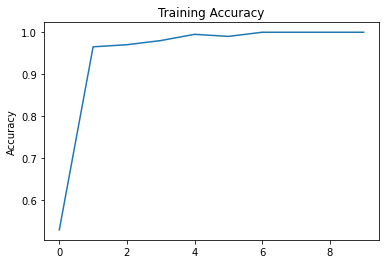

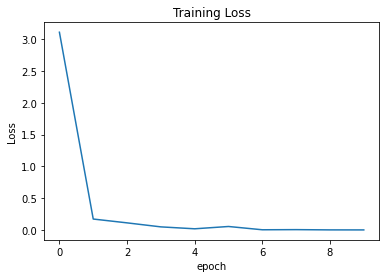

In [36]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Fotos/toddy.jpeg', target_size=(224,224))

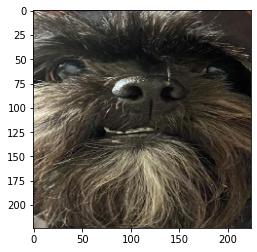

In [39]:
plt.imshow(sample_image);

In [40]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
np.shape(sample_image)

(224, 224, 3)

In [41]:
sample_image = np.expand_dims(sample_image, axis = 0)
np.shape(sample_image)

(1, 224, 224, 3)

In [42]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [43]:
predictions = model.predict(sample_image)
print(predictions)

[[1.38634521e-10 3.31263433e-10 1.02310271e-10 4.73804572e-11
  4.93265817e-10 8.62420468e-10 4.96501507e-10 5.00773023e-09
  2.29096164e-09 2.92959950e-08 2.08110994e-11 1.38305437e-10
  2.05302930e-09 2.92068258e-09 4.61816807e-10 1.00633564e-08
  7.71397346e-09 3.63281920e-08 1.71876624e-09 3.88090893e-09
  1.11952753e-10 1.34505482e-08 1.45381984e-10 4.00614576e-11
  2.31867112e-08 7.71253963e-11 5.23500444e-11 1.80411158e-10
  9.85773546e-11 5.04741748e-10 7.14976828e-11 7.04845644e-12
  1.26698776e-10 2.40745451e-10 6.97224833e-10 6.25385410e-10
  2.97611291e-09 1.11162066e-10 9.13696896e-11 2.10224768e-10
  4.07868218e-11 1.13104937e-09 2.03473211e-11 6.97963298e-10
  2.24682536e-10 5.93843907e-09 1.89929489e-10 3.04851699e-11
  3.57194448e-11 8.74633907e-11 1.25976521e-11 3.46802864e-11
  2.59395190e-08 4.17391277e-09 1.83625009e-08 1.00480069e-09
  1.12394911e-08 5.79407189e-10 1.86040483e-09 1.72298398e-09
  9.03380215e-09 4.04001776e-10 5.01757791e-09 9.47831147e-09
  1.0091

In [54]:
predictions = model.predict(sample_image)
tf.keras.applications.resnet.decode_predictions(predictions, top=5)

[[('n02110627', 'affenpinscher', 0.9447125),
  ('n02112706', 'Brabancon_griffon', 0.046689723),
  ('n02086240', 'Shih-Tzu', 0.0065218336),
  ('n02096177', 'cairn', 0.0007493041),
  ('n02097047', 'miniature_schnauzer', 0.0005795311)]]

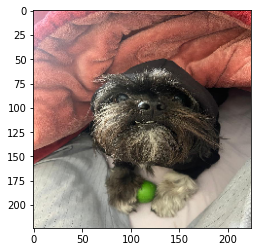

In [55]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Fotos/WhatsApp Image 2022-08-11 at 17.51.55.jpeg', target_size=(224,224))
plt.imshow(sample_image);

In [56]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image = np.expand_dims(sample_image, axis = 0)
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)
predictions = model.predict(sample_image)
predictions = model.predict(sample_image)
tf.keras.applications.resnet.decode_predictions(predictions, top=5)

[[('n02808304', 'bath_towel', 0.81045663),
  ('n02086240', 'Shih-Tzu', 0.08249142),
  ('n02098413', 'Lhasa', 0.015174657),
  ('n02110627', 'affenpinscher', 0.012010979),
  ('n02086079', 'Pekinese', 0.011205183)]]

### Object Detection

In [ ]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

In [61]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [62]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url, 
                                                        input_shape=(224,224,3))])

In [65]:
path = "/content/drive/MyDrive/Datasets/Transfer-Learning-Data 2.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

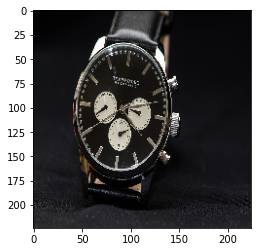

In [72]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/watch.jpg', target_size = (224, 224))
plt.imshow(sample_image);

In [73]:
sample_image = np.array(sample_image) / 255.0
sample_image.shape

(224, 224, 3)

In [77]:
pred_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis=0))
pred_class = np.argmax(pred_class)
pred_class

827

In [78]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [79]:
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

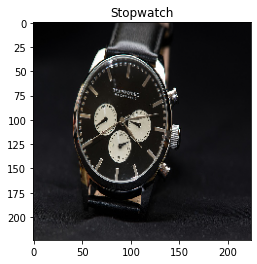

In [80]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[pred_class]
plt.title(predicted_class_name.title());

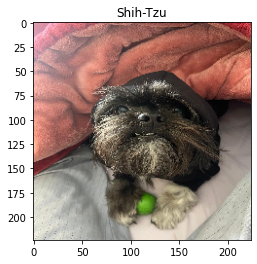

In [81]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Fotos/WhatsApp Image 2022-08-11 at 17.51.55.jpeg', target_size = (224, 224))
sample_image = np.array(sample_image) / 255.0
pred_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis=0))
pred_class = np.argmax(pred_class)
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[pred_class]
plt.title(predicted_class_name.title());

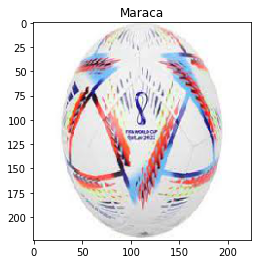

In [82]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Fotos/bola.jfif', target_size = (224, 224))
sample_image = np.array(sample_image) / 255.0
pred_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis=0))
pred_class = np.argmax(pred_class)
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[pred_class]
plt.title(predicted_class_name.title());

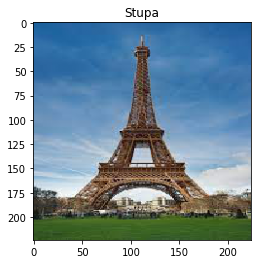

In [83]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Fotos/torre.jfif', target_size = (224, 224))
sample_image = np.array(sample_image) / 255.0
pred_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis=0))
pred_class = np.argmax(pred_class)
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[pred_class]
plt.title(predicted_class_name.title());

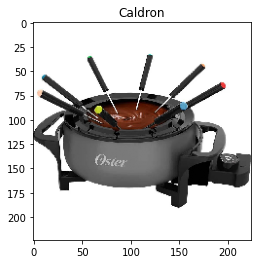

In [84]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Fotos/panela-de-fondue-eletrica-oster-c--8-garfos-1000w-ofnd100_694319_1.jpg', target_size = (224, 224))
sample_image = np.array(sample_image) / 255.0
pred_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis=0))
pred_class = np.argmax(pred_class)
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[pred_class]
plt.title(predicted_class_name.title());

In [113]:
flowers_data_url = tf.keras.utils.get_file('flower_photos', 
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

228827136/228813984 [==============================] - 1s 0us/step


In [114]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=True)

Found 3670 images belonging to 5 classes.


In [115]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ", flowers_data_label_batch.shape)
  break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


In [116]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

(64, 1001)

In [117]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

array(['conch', 'pot', 'hummingbird', 'daisy', 'daisy', 'orange',
       'picket fence', 'daisy', 'daisy', 'tractor', 'microwave',
       'mushroom', 'daisy', 'daisy', 'Bedlington terrier', 'daisy',
       'bell pepper', 'cardoon', 'daisy', 'conch', 'picket fence',
       'daisy', 'cock', 'picket fence', 'daisy', 'daisy', 'lorikeet',
       'cardoon', 'rapeseed', 'picket fence', 'coral fungus', 'daisy',
       'goldfish', 'coral fungus', 'daisy', 'zucchini', 'pot',
       'sea urchin', 'hair slide', 'broom', 'daisy', 'daisy', 'teddy',
       'daisy', 'daisy', 'cardoon', 'daisy', 'daisy', 'pot', 'bee',
       'rapeseed', 'pot', 'bee', 'pot', 'brassiere', 'vase', 'daisy',
       'pinwheel', 'shovel', 'coral fungus', 'daisy', 'daisy', 'coil',
       'lemon'], dtype='<U30')

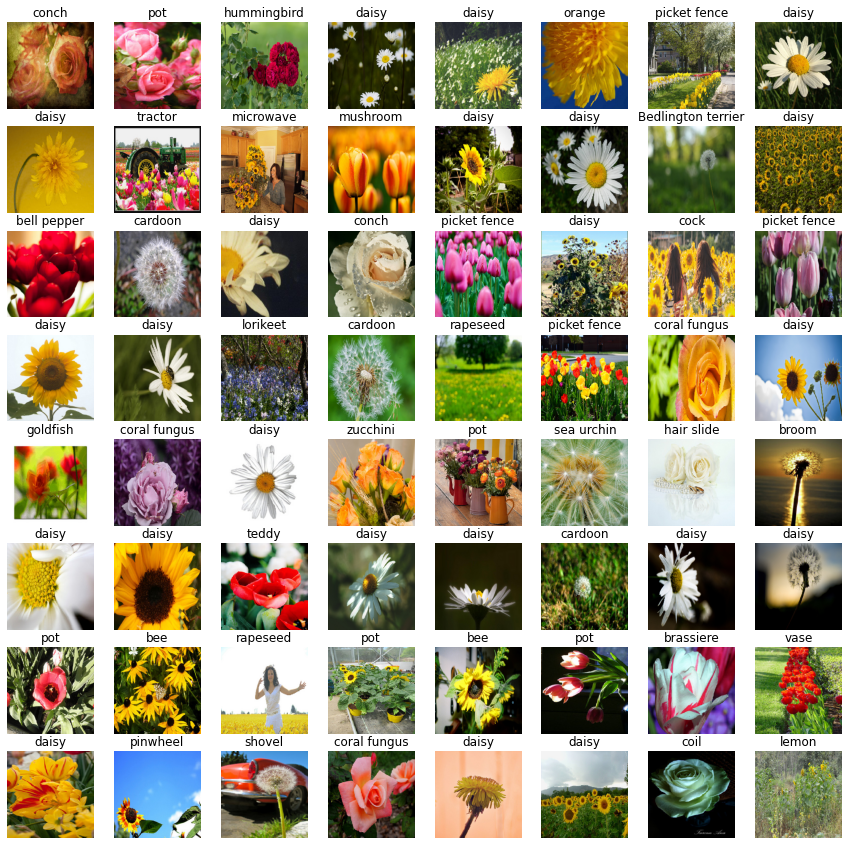

In [123]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

In [124]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [125]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape=(224, 224, 3))

In [126]:
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape

TensorShape([64, 1280])

In [127]:
MobileNet_feature_extractor_layer.trainable = False

In [128]:
flower_data.num_classes

5

In [129]:
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation='softmax')])

In [130]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [131]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [132]:
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [133]:
history = model.fit_generator(flower_data, epochs=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
58/58 [==============================] - 16s 220ms/step - loss: 1.0107 - accuracy: 0.6234
Epoch 2/50
58/58 [==============================] - 13s 219ms/step - loss: 0.5668 - accuracy: 0.8144
Epoch 3/50
58/58 [==============================] - 13s 228ms/step - loss: 0.4635 - accuracy: 0.8471
Epoch 4/50
58/58 [==============================] - 13s 217ms/step - loss: 0.4066 - accuracy: 0.8678
Epoch 5/50
58/58 [==============================] - 14s 239ms/step - loss: 0.3692 - accuracy: 0.8828
Epoch 6/50
58/58 [==============================] - 13s 219ms/step - loss: 0.3396 - accuracy: 0.8886
Epoch 7/50
58/58 [==============================] - 13s 217ms/step - loss: 0.3171 - accuracy: 0.8992
Epoch 8/50
58/58 [==============================] - 13s 217ms/step - loss: 0.2976 - accuracy: 0.9044
Epoch 9/50
58/58 [==============================] - 14s 236ms/step - loss: 0.2815 - accuracy: 0.9117
Epoch 10/50
58/58 [==============================] - 13s 215ms/step - loss: 0.2677 - accura

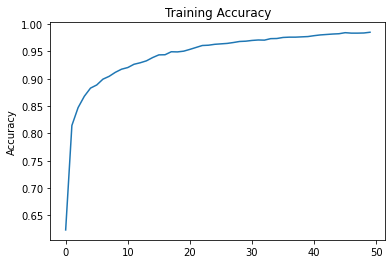

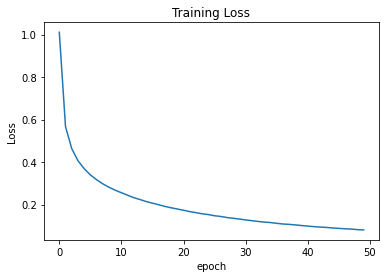

In [134]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [135]:
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [136]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [137]:
class_names = np.array([key.title() for key, value in class_names])

In [138]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [139]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [140]:
predicted_id

array([2, 2, 2, 0, 1, 1, 4, 0, 1, 4, 3, 4, 3, 0, 1, 3, 4, 1, 0, 2, 4, 3,
       3, 4, 3, 0, 4, 1, 1, 4, 2, 3, 2, 2, 0, 2, 2, 1, 2, 1, 0, 3, 4, 0,
       0, 1, 0, 1, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 1, 2, 1, 3, 2, 3])

In [141]:
predicted_label_batch

array(['Roses', 'Roses', 'Roses', 'Daisy', 'Dandelion', 'Dandelion',
       'Tulips', 'Daisy', 'Dandelion', 'Tulips', 'Sunflowers', 'Tulips',
       'Sunflowers', 'Daisy', 'Dandelion', 'Sunflowers', 'Tulips',
       'Dandelion', 'Daisy', 'Roses', 'Tulips', 'Sunflowers',
       'Sunflowers', 'Tulips', 'Sunflowers', 'Daisy', 'Tulips',
       'Dandelion', 'Dandelion', 'Tulips', 'Roses', 'Sunflowers', 'Roses',
       'Roses', 'Daisy', 'Roses', 'Roses', 'Dandelion', 'Roses',
       'Dandelion', 'Daisy', 'Sunflowers', 'Tulips', 'Daisy', 'Daisy',
       'Dandelion', 'Daisy', 'Dandelion', 'Tulips', 'Sunflowers',
       'Tulips', 'Sunflowers', 'Sunflowers', 'Tulips', 'Tulips', 'Tulips',
       'Tulips', 'Sunflowers', 'Dandelion', 'Roses', 'Dandelion',
       'Sunflowers', 'Roses', 'Sunflowers'], dtype='<U10')

In [142]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([2, 2, 2, 0, 1, 1, 4, 0, 1, 4, 3, 4, 3, 0, 1, 3, 4, 1, 0, 2, 4, 3,
       3, 4, 3, 0, 4, 1, 1, 4, 2, 3, 2, 2, 0, 2, 2, 1, 2, 1, 0, 3, 4, 0,
       0, 1, 0, 1, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 1, 2, 1, 3, 2, 3])

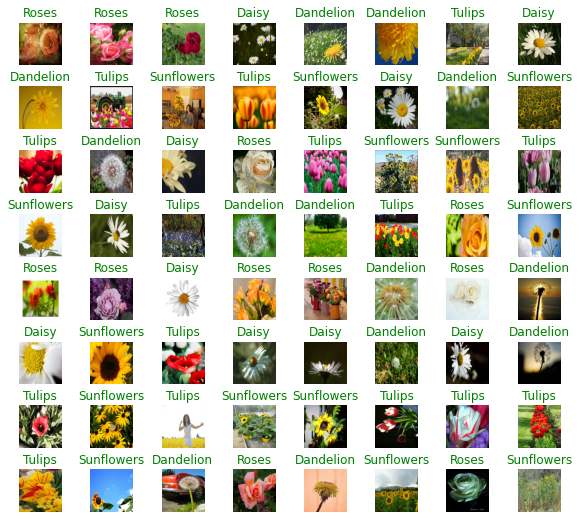

In [143]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')